In [1]:
from examples.lorenz import _lorenz
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mlresn.esn import EsnForecaster, ACTIVATIONS
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 12

# Data preparation

In [6]:
np.random.seed(0)
%time y, t_long = _lorenz(np.random.rand(3,), 0.01, 1000)

KeyboardInterrupt: 

NameError: name 't_long' is not defined

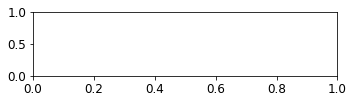

In [163]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t_long, y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    plt.plot(t_long[-2000:], y[-2000:, i])

In [3]:
np.random.seed(0)
y, t = _lorenz(np.random.rand(3,), 0.01, 60)
ss = StandardScaler()
t = t[:-2000]
ts = ss.fit_transform(y)[2000:]/2.

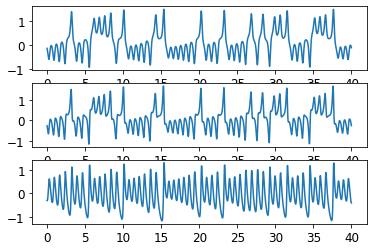

In [4]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t, ts[:, i])

In [5]:
def prediction_generator(forecaster, y, n_splits = 10, n_test_timesteps = 100):
    n_train = len(y) - n_splits * n_test_timesteps
    t = np.linspace(0, len(y)-1, len(y))
    for i in range(n_splits):
        _n_train = n_train + i * n_test_timesteps
        forecaster.fit(y=y[:_n_train])
        y_pred = forecaster.predict(n_test_timesteps)
        yield slice(_n_train, _n_train+n_test_timesteps), y_pred

# ESN fitting

## Tanh activation

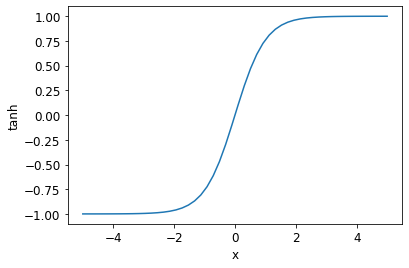

In [43]:
f = ACTIVATIONS["tanh"]["direct"]
_t = np.linspace(-5, 5)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("tanh")
plt.savefig("ESNactivations_tanh.png",dpi=300)

In [19]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='tanh',
    random_state=0,
)

In [20]:
model.fit(ts[:-2000])

EsnForecaster(lambda_r=0.0001, n_reservoir=300, random_state=0,
              regularization='l2', sparsity=0.1, spectral_radius=1.1,
              use_additive_noise_when_forecasting=False)

In [21]:
pred = model.predict(2000)

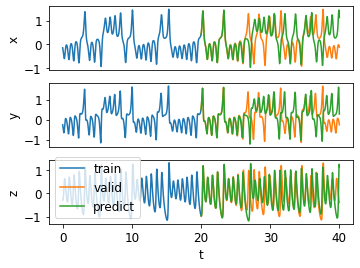

In [22]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
plt.legend()

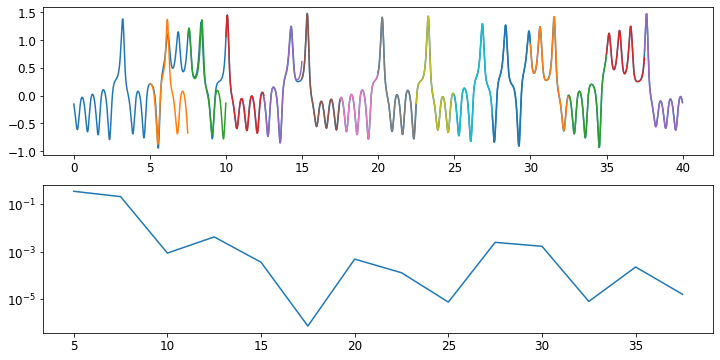

In [23]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
tanh_errors = errors.copy()
plt.subplot(2,1,2)
plt.semilogy(t[::250], errors)

In [212]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 18.4 s


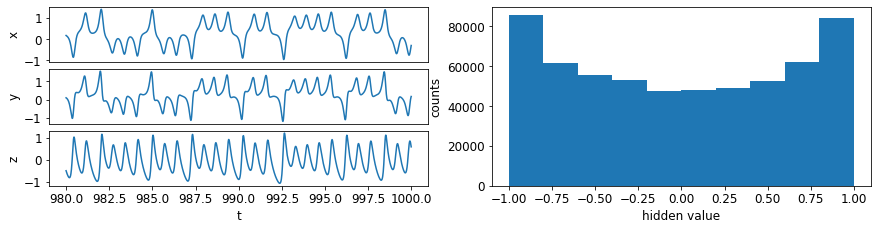

In [213]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_tanh_long.png",dpi=300)

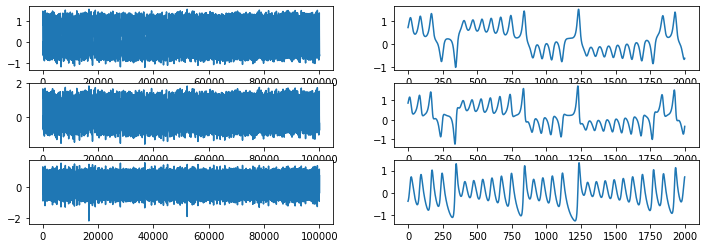

In [14]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])

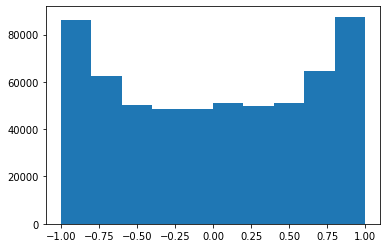

In [15]:
_ = plt.hist(r[-2000:].reshape(-1))

## ReLU activation

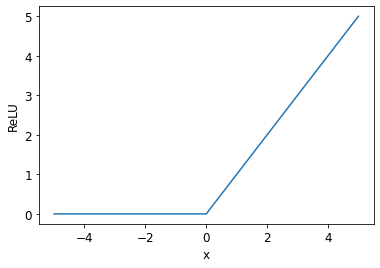

In [29]:
f = ACTIVATIONS["relu"]["direct"]
_t = np.linspace(-5, 5, 101)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("ReLU")
plt.savefig("ESNactivations_relu.png",dpi=300)

In [30]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='relu',
    out_activation='identity',
    use_additive_noise_when_forecasting=True,
    random_state=0,
    use_bias=True
)

In [31]:
model.fit(ts[:-2000])

EsnForecaster(in_activation='relu', lambda_r=0.0001, n_reservoir=300,
              random_state=0, regularization='l2', sparsity=0.1,
              spectral_radius=1.1, use_additive_noise_when_forecasting=False)

In [32]:
pred = model.predict(2000)

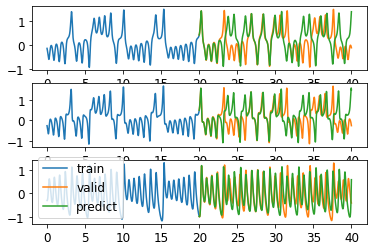

In [33]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
plt.legend()

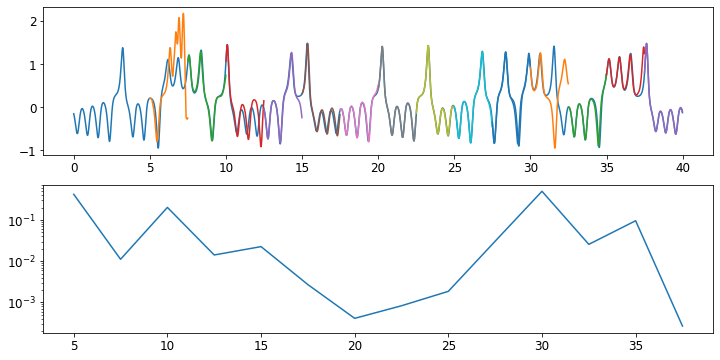

In [34]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
rel_errors = errors.copy()
plt.subplot(2,1,2)
plt.semilogy(t[::250], errors)

In [202]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 16.6 s


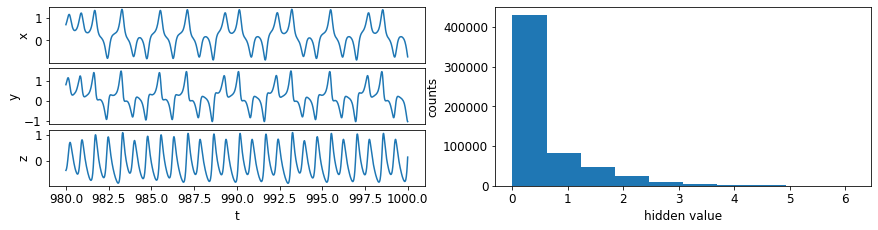

In [209]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_relu_long.png",dpi=300)

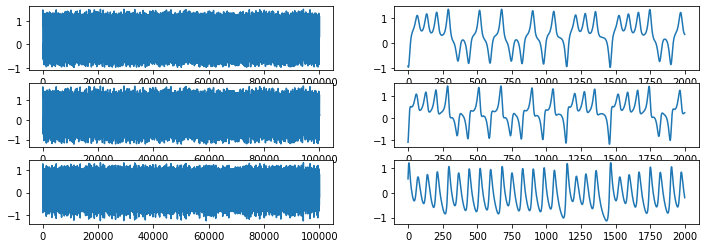

In [23]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])

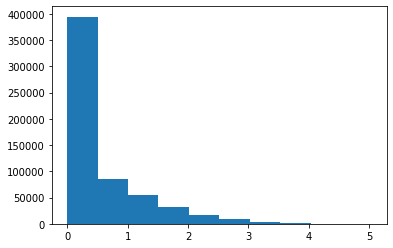

In [24]:
relu_states = r[-2000:].reshape(-1)
_ = plt.hist(r[-2000:].reshape(-1))

## Leaky ReLU

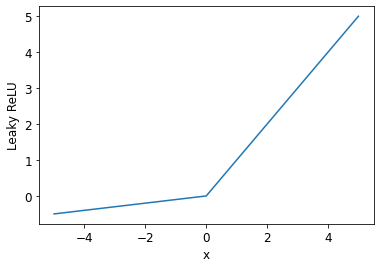

In [259]:
ACTIVATIONS["leaky_relu"]["direct"] = lambda x: np.maximum(0.,x) + np.minimum(0.,x)*0.1
f = ACTIVATIONS["leaky_relu"]["direct"]
_t = np.linspace(-5, 5, 101)
# plt.plot([-5,5], [0,0], color="black", lw=0.5)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("Leaky ReLU")
plt.savefig("ESNactivations_lrelu.png",dpi=300)

In [260]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='leaky_relu',
    out_activation='identity',
    use_additive_noise_when_forecasting=True,
    random_state=0,
    use_bias=True
)

In [261]:
model.fit(ts[:-2000])

EsnForecaster(in_activation='leaky_relu', lambda_r=0.0001, n_reservoir=300,
              random_state=0, regularization='l2', sparsity=0.1,
              spectral_radius=1.1, use_additive_noise_when_forecasting=False)

In [262]:
pred = model.predict(2000)

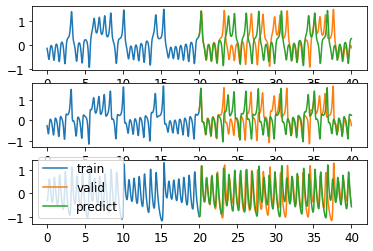

In [263]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
plt.legend()

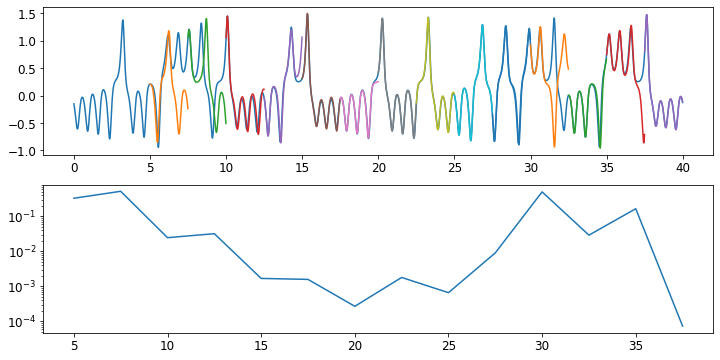

In [264]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
plt.subplot(2,1,2)
plt.semilogy(t[::250], errors)

In [265]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 18.1 s


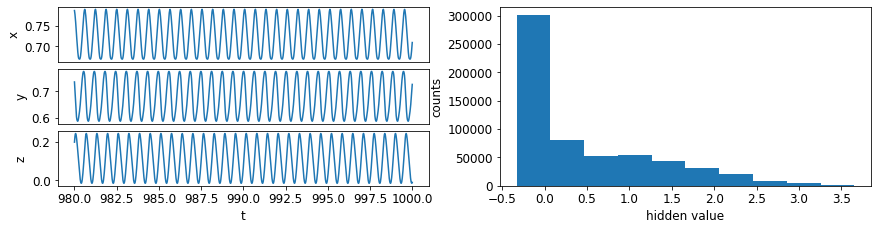

In [266]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_lrelu_long.png",dpi=300)

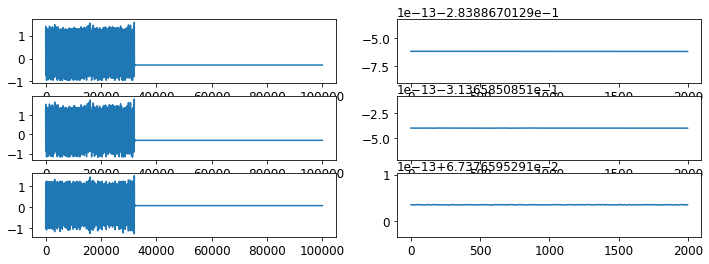

In [253]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])

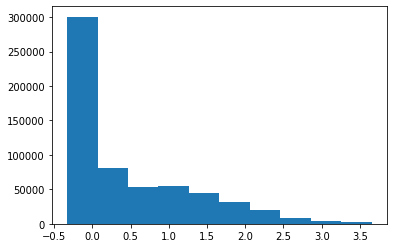

In [51]:
# plt.hist(relu_states)
_ = plt.hist(r[-2000:].reshape(-1))

## Flat ReLU

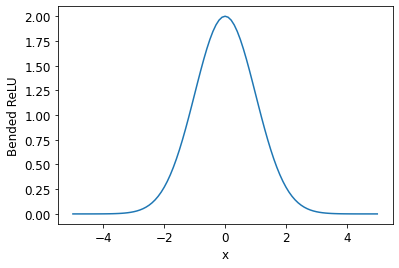

In [58]:
f = ACTIVATIONS["flat_relu"]["direct"]
_t = np.linspace(-5, 5, 101)
# plt.plot([-5,5], [0,0], color="black", lw=0.5)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("Bended ReLU")
plt.savefig("ESNactivations_brelu.png",dpi=300)

In [59]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='flat_relu',
    out_activation='identity',
    use_additive_noise_when_forecasting=True,
    random_state=0,
    use_bias=True
)

In [60]:
model.fit(ts[:-2000])

EsnForecaster(in_activation='flat_relu', lambda_r=0.0001, n_reservoir=300,
              random_state=0, regularization='l2', sparsity=0.1,
              spectral_radius=1.1, use_additive_noise_when_forecasting=False)

In [61]:
pred = model.predict(2000)

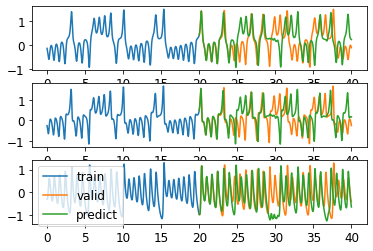

In [62]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
plt.legend()

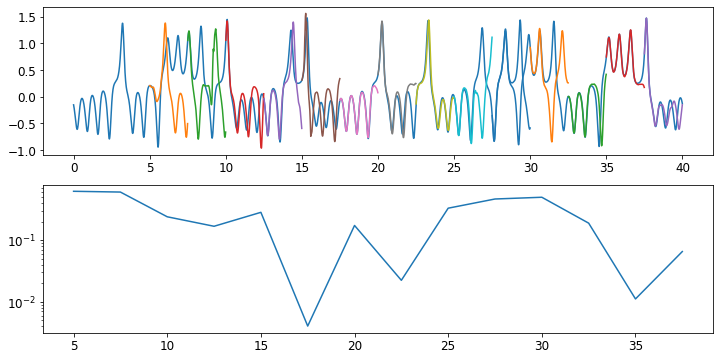

In [63]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
plt.subplot(2,1,2)
plt.semilogy(t[::250], errors)

In [65]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 21.1 s


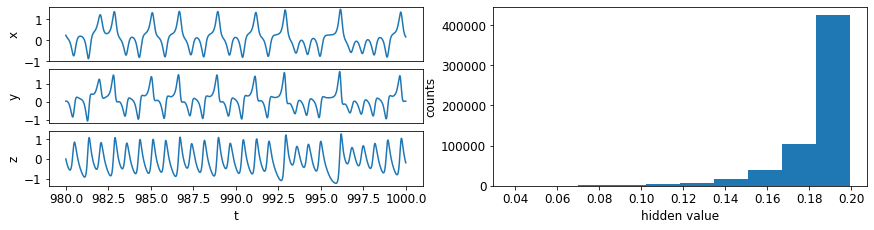

In [64]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_brelu_long.png",dpi=300)

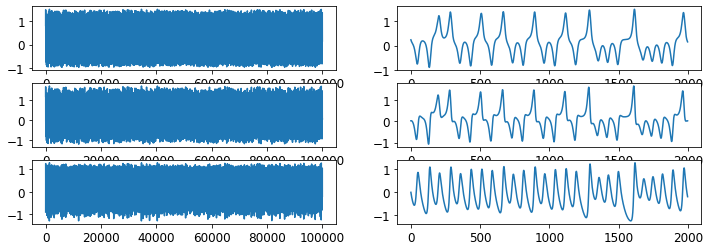

In [57]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])

# Gauss

Text(0, 0.5, 'Gauss')

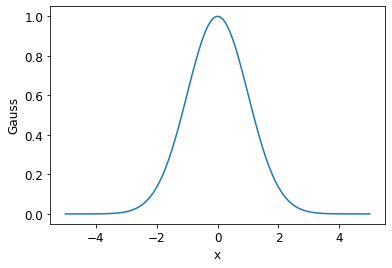

In [50]:
f = ACTIVATIONS["gauss"]["direct"]
_t = np.linspace(-5, 5, 101)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("Gauss")

In [78]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='gauss',
    out_activation='identity',
    use_additive_noise_when_forecasting=True,
    random_state=0,
    use_bias=True
)

In [79]:
model.fit(ts[:-2000])

EsnForecaster(in_activation='gauss', lambda_r=0.0001, n_reservoir=300,
              random_state=0, regularization='l2', sparsity=0.1,
              spectral_radius=1.1, use_additive_noise_when_forecasting=False)

In [80]:
pred = model.predict(2000)

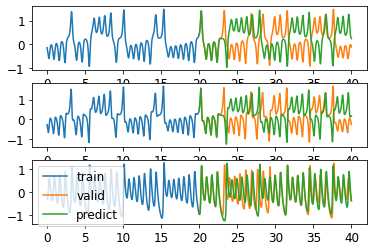

In [81]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
plt.legend()

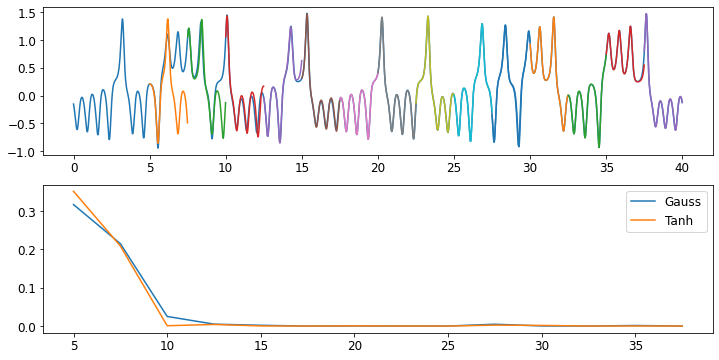

In [84]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
plt.subplot(2,1,2)
plt.plot(t[::250], errors, label="Gauss")
plt.plot(t[::250], tanh_errors, label="Tanh")

plt.legend()

In [83]:
errors[errors != None].mean(), tanh_errors[tanh_errors != None].mean()

(0.04058900211765344, 0.04080648982684809)

In [22]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 19.3 s


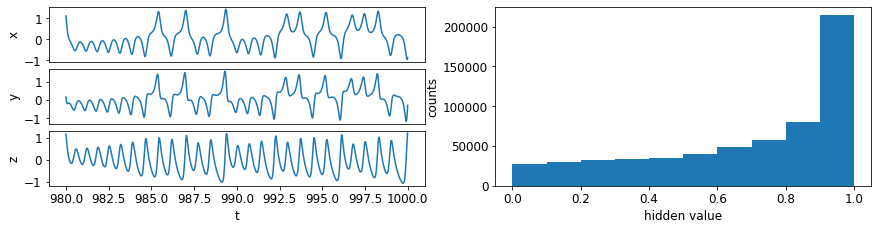

In [23]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_brelu_long.png",dpi=300)

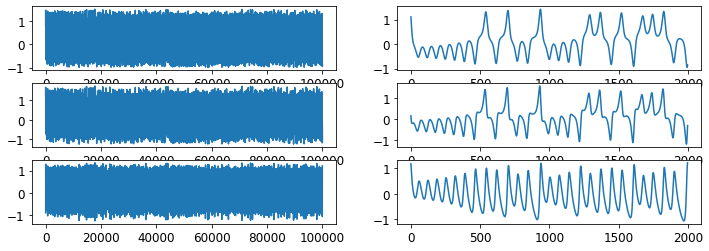

In [24]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])

# ReL Gauss

Text(0, 0.5, 'ReL Gauss')

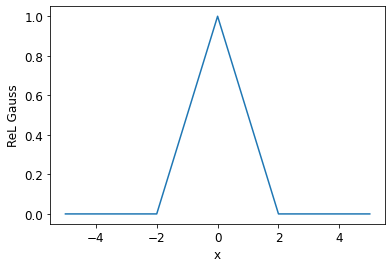

In [56]:
f = ACTIVATIONS["rel_gauss"]["direct"]
_t = np.linspace(-5, 5, 101)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("ReL Gauss")

In [85]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='rel_gauss',
    out_activation='identity',
    use_additive_noise_when_forecasting=True,
    random_state=0,
    use_bias=True
)

In [86]:
model.fit(ts[:-2000])

EsnForecaster(in_activation='rel_gauss', lambda_r=0.0001, n_reservoir=300,
              random_state=0, regularization='l2', sparsity=0.1,
              spectral_radius=1.1, use_additive_noise_when_forecasting=False)

In [87]:
pred = model.predict(2000)

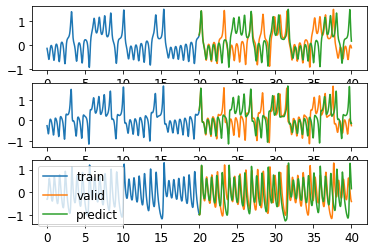

In [88]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
plt.legend()

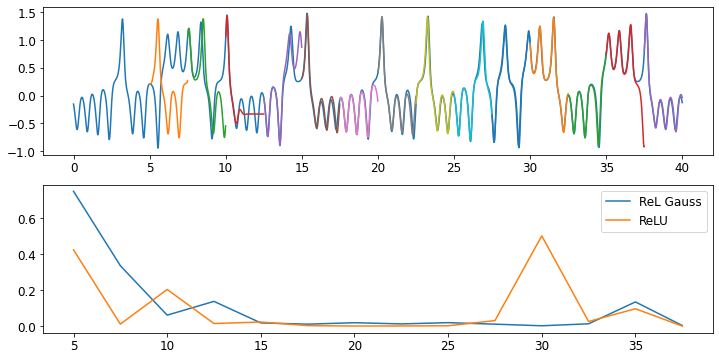

In [89]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
plt.subplot(2,1,2)
plt.plot(t[::250], errors, label="ReL Gauss")
plt.plot(t[::250], rel_errors, label="ReLU")

plt.legend()

In [90]:
errors[errors != None].mean(), rel_errors[rel_errors != None].mean()

(0.1088935508645076, 0.0953633169717257)

In [26]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 24.8 s


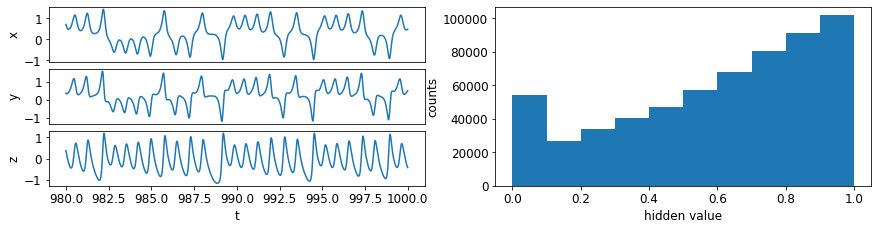

In [27]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_brelu_long.png",dpi=300)

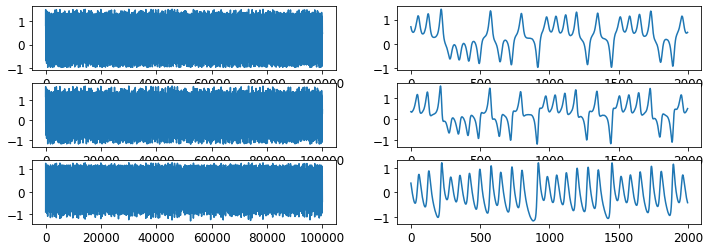

In [28]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])

# Sin

Text(0, 0.5, 'Sin')

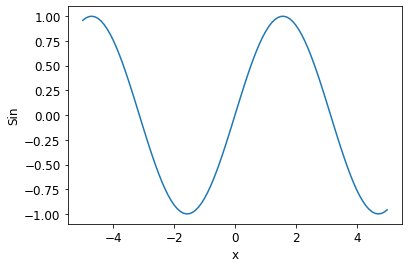

In [24]:
f = ACTIVATIONS["sin"]["direct"]
_t = np.linspace(-5, 5, 101)
plt.plot(_t, f(_t))
plt.xlabel("x")
plt.ylabel("Sin")

In [25]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=1.1,
    sparsity=0.1,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='sin',
    out_activation='identity',
    use_additive_noise_when_forecasting=True,
    random_state=0,
    use_bias=True
)

In [26]:
model.fit(ts[:-2000])

EsnForecaster(in_activation='sin', lambda_r=0.0001, n_reservoir=300,
              random_state=0, regularization='l2', sparsity=0.1,
              spectral_radius=1.1, use_additive_noise_when_forecasting=False)

In [27]:
pred = model.predict(2000)

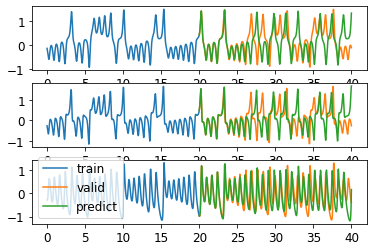

In [28]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-2000], ts[:-2000, i], label = "train")
    plt.plot(t[-2000:], ts[-2000:, i], label = "valid")
    plt.plot(t[-2000:], pred[:, i], label = "predict")
plt.legend()

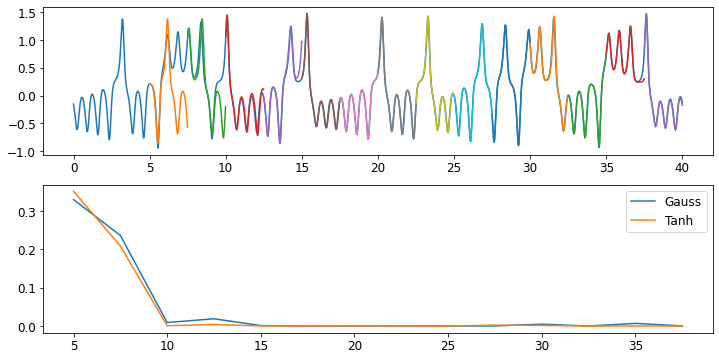

In [29]:
pgen = prediction_generator(model, ts, 14, 250)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t, ts[:, 0])
errors = [None]*(len(ts)//250-14)
for test_sl, test_ts in pgen:
    plt.plot(t[test_sl], test_ts[:, 0])
    errors.append(mean_squared_error(test_ts, ts[test_sl]))
errors = np.array(errors)
plt.subplot(2,1,2)
plt.plot(t[::250], errors, label="Sin")
plt.plot(t[::250], tanh_errors, label="Tanh")

plt.legend()

In [30]:
errors[errors != None].mean(), tanh_errors[tanh_errors != None].mean()

(0.04351393007909555, 0.04080648982684809)

In [31]:
%time y, r = model.predict(100000, return_states=True)

Wall time: 18.2 s


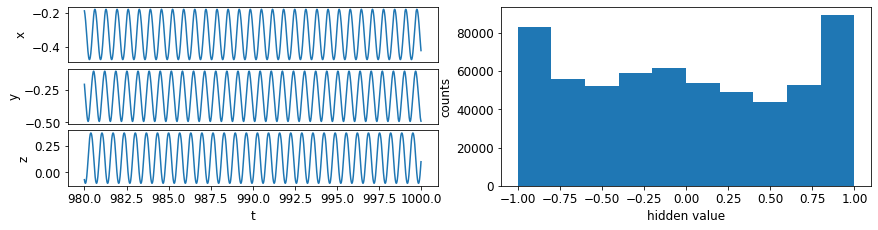

In [32]:
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    plt.plot(t[-2000:]+960, y[-2000:, i])
    if(i < 2): plt.xticks([])
    else: plt.xlabel("t")
    plt.ylabel("xyz"[i])
    
plt.subplot(1, 2, 2)
plt.hist(r[-2000:].reshape(-1))
plt.xlabel("hidden value")
plt.ylabel("counts")
plt.tight_layout(pad=0)
plt.savefig("ESNactivations_brelu_long.png",dpi=300)

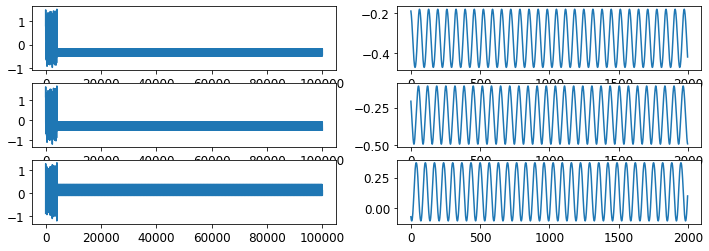

In [33]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3, 2, i*2+1)
    # plt.plot(t_long, y[:, i])
    plt.plot(y[:, i])
for i in range(3):
    plt.subplot(3, 2, i*2+2)
    # plt.plot(t_long[-2000:], y[-2000:, i])
    plt.plot(y[-2000:, i])